# **Tutorial on Record Selection**
## METIS Summer School Pavia 2022
--------------------------------------------------------------------------------


# Getting started
This is a machine in google so we have to install the requirements for record selection, openquake, etc...



In [ ]:
%%capture
pip uninstall --yes numba

In [ ]:
%%capture
pip install --pre numba

In [ ]:
%%capture
pip install openquake.engine

Next step is to identify the directories for the various inputs, coming from ***PSHA*** and ***disaggregation***, the ground motion ***DB*** metadata and the ***outputs***

In [3]:
# These are created within the machine 
out_dir= r"D:/Documents/PhD\METIS/Summer_school/Summer_school/output" # directory for outputs
fig_dir = r"D:/Documents/PhD/METIS/Summer_school/Summer_school/output/figures"  # directory where the figures are stored
output_dir = r"D:/Documents/PhD/METIS/Summer_school/Summer_school/output/outputGM"  # directory where ground motion outputs are stored
# These will come from github
mat_dir = r"D:/Documents/PhD/METIS/Summer_school/Summer_school/SSgithub/SummerSchool/Data/DB_final_6.mat"  # mat file with the Database of records - metadata flatfile
path_dis = r"D:\Documents\PhD\METIS\Summer_school\Summer_school\SSgithub\SummerSchool\Data\PSHA_Output\Disaggregation\Py_1"  # output from OQ
path_haz = r"D:\Documents\PhD\METIS\Summer_school\Summer_school\SSgithub\SummerSchool\Data\PSHA_Output\Hazard\Py_1"  # output from OQ

The last part of the setup will be getting the functions and datasets from `github`. Some output from PSHA and disaggregation for T(1.0s) is also there.

In [ ]:
!git clone https://github.com/pablogqipv/SummerSchool

Cloning into 'SummerSchool'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 241 (delta 80), reused 101 (delta 77), pack-reused 136
Receiving objects: 100% (241/241), 54.75 MiB | 39.84 MiB/s, done.
Resolving deltas: 100% (173/173), done.


# ESM Database
In order to select records, we require a database to pull them from, it is important that it contains relevant information on the causative parameters as well as the intensities of the event. Here, the mat file contains all the relevant information about the records, such as spectral quantities, Magnitude, distance to station, depth, Vs30, etc.



---



Loading the functions and packages and creating directories...

In [4]:
import os
import os.path
from os import path
import math

if path.exists(out_dir) == False:
  os.mkdir(out_dir)
if path.exists(output_dir) == False:
  os.mkdir(output_dir)
if path.exists(fig_dir) == False:
  os.mkdir(fig_dir)
if path.exists(output_dir) == False:
  os.mkdir(output_dir)

os.chdir("D:\Documents\PhD\METIS\Summer_school\Summer_school\SSgithub\SummerSchool")
import numpy as np
from utils_bsc import CS
from time import time
from OQProc import disagg_MReps, hazard
import os
import pickle
from matplotlib import pyplot as plt
import warnings
from Saveutils import fxn, saveMat, plot_select_recs

# Conditional spectrum 
The conditional spectrum, as previously stated is a target based record selection procedure which accounts for the variability in the hazard. 
The steps mainly followed by this procedure which will be detailed through the next steps are:
  1. Definition of target periods, intensities, GM, limits, etc.
  2. Disaggregation of the hazard for a given period ***T*** and a given ***probability of exceedance*** (or RP).
  3. Definition of the target spectrum, mean and variance.
  4. Ground motion selection through sampling.
  5. Optimization.

## The algorithm

Script used to select the records based on the Sa(T*) value. It is based (with some modifications) on: https://github.com/volkanozsarac/EzGM.git;

Calculation of SSEs is from "A Computationally Efficient Ground-Motion Selection Algorithm for Matching a Target Response
    Spectrum Mean and Variance" Jayaram, 2011:  https://journals.sagepub.com/doi/pdf/10.1193/1.3608002;

Any GMPE available in the OQ library can be used. If we set pinfo=1 we will get information about GMPE (e.g. for which
    IM it was derived)
make sure that you use same GMPE in hazard calculation (in OQ) and for the selection

Main processes about CS are found in the `utils_bsc` script, we will see some parts of the code within here as we execute the commands...



# Main Inputs

Now we set the inputs: level of intensity, number of records to select,Vs30 and scaling limits, etc.

Additionally we define the inputs for the GMPE to be used for the target spectrum

In [5]:
poes = [0.7, 0.5, 0.3, 0.1, 0.05, 0.02, 0.015, 0.01, 0.006, 0.002]  # probability of exceedance in 50 years
T_target = [0.075, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.50, 1.6,
            1.7, 1.8, 1.9, 2.00, 3.00, 4.00]  # periods of interest for target spectrum

nIM = 6     # IML for calculation (out of the list of poes)
T_star = 1  # period of interest
Mbin = 0.5  # the values used in hazard calculation (OQ)
dbin = 10   # the values used in hazard calculation (OQ)
nGM = 40      # number of GM to select
Vs30_lims=[600,2500] # Vs30 limits in m/s
maxSF =  4.0  # max scaling factor
minSF = 0.2 # min scaling factor


# Input for the GMPE (depends on the GMPE)
rake = 180
Vs30 = 800
Fhw = 1


# Disaggregation analysis
In order to create a target spectrum, it is necessary to understand which events will have the most contribution to the hazard, this will allow us to get the target scenario's causative parameters:
 Magnitude (***M***), Distance (***R***) and ***$\epsilon$***



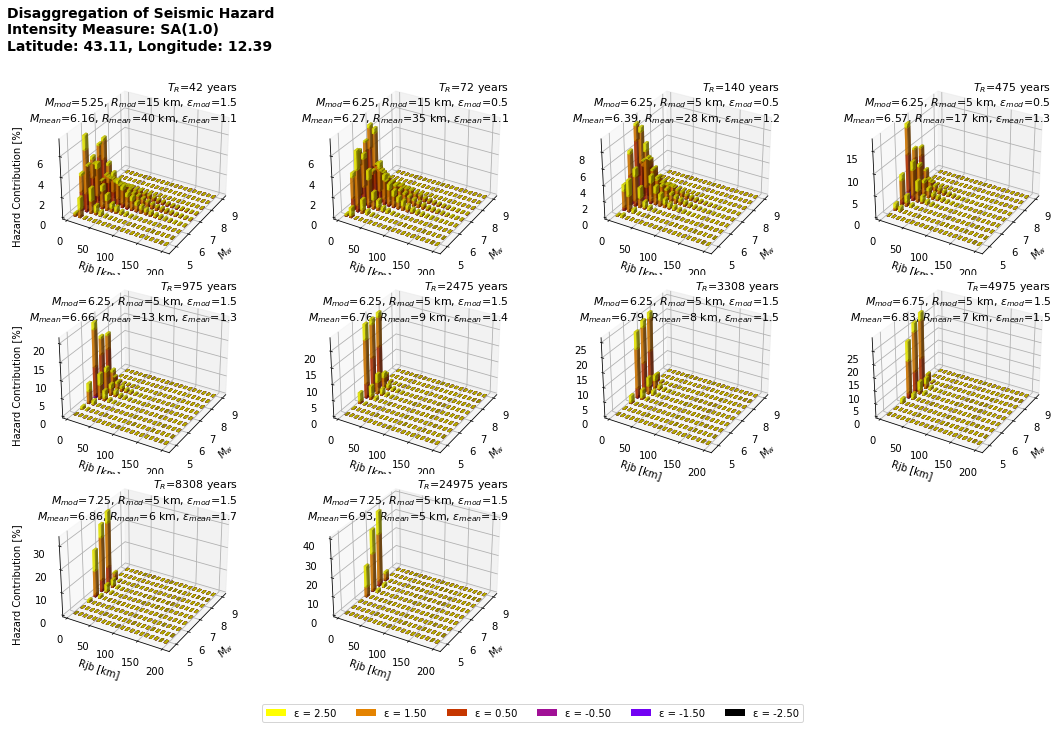

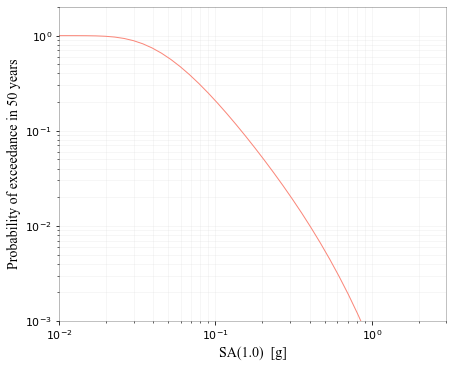

In [6]:

# Read the results of the disaggregation and get M, R and epsilon values
meanLst, modeLst, _, _, _ = disagg_MReps(Mbin, dbin, poes, path_dis, fig_dir,n_rows=3,
                                iplot=True)  # mean and mode scenarios from disaggregation (M, R and epsilon) --- slow
imls = hazard(poes, path_haz, output_dir=fig_dir,
              rlz='hazard_curve-mean', i_save=1, i_show=1)  # IMs at the predefined levels (poes)


# Creating the target
The next step is to create the target spectra using the GMPE with the values obtained from the disaggregation analysis at the intensity level (IML) of choice.

First we get the required values:

In [7]:
All_CS = []
j=nIM-1
print("IM level:", str(nIM))
# Initialize the CS class
CS1 = CS(mat_dir, T_star=T_star, gmpe='BooreAtkinson2008', pInfo=1)
mag = meanLst[j][0]
rjb = meanLst[j][1]
eps = meanLst[j][2]  # not used here
im_T_star = imls[0][j]
print("Poe is:", 100*poes[j], "% in 50 years.", "Mean Magnitude and Rjb are:", np.round(mag, 2), np.round(rjb, 2))
print("IM at the level", str(nIM), "is:", np.round(im_T_star, 3))
SOF, W, dip, Ztor, Rrup, Rx, Ryo, Z1 = CS1.getUnknown_params(M=mag, Fhw=Fhw, rake=rake, Rjb=rjb, Vs30=Vs30)


IM level: 6
For the selected gmpe;
 The mandatory input distance parameters are ['rjb']
 The mandatory input rupture parameters are ['mag', 'rake']
 The mandatory input site parameters are ['vs30']
 The defined intensity measure component is IMC.GMRotI50
 The defined tectonic region type is TRT.ACTIVE_SHALLOW_CRUST

Poe is: 2.0 % in 50 years. Mean Magnitude and Rjb are: 6.76 8.83
IM at the level 6 is: 0.305




---


Now, we create the target spectrum using the required data for the GMPE and values from disaggregation. 


This will allow us to create our mean conditional target spectrum with:



 $\mu_{lnSa(T_i)|lnSa(T*)} = \mu_{lnSa}(M,R,T_i)+\rho(T_i,T*)\epsilon(T*)\sigma_{lnSa}(T_i)$



 Where  $\mu_{lnSa}(M,R,T_i)$ is the unconditional mean spectrum, computed simply through the GMPE

 In the code it can be found as:

```
........
# Whithin the funciton create()
........
for i in range(len(T_Tgt)):
  # Get the GMPE output for a rupture scenario
  mu0, sigma0 = self.bgmpe.get_mean_and_stddevs(sites, rup, dists, imt.SA(period=T_Tgt[i]),
                                                [const.StdDev.TOTAL])
  mu_lnSaT[i] = mu0[0]
  sigma_lnSaT[i] = sigma0[0][0]

  if self.cond == 1:
      # Compute the correlations between each T and T_star
      rho_T_T_star[i] = self.rho_AvgSa_Sa(self.bgmpe, scenario, T_Tgt[i], self.T_star)

if self.cond == 1:
  # Get the GMPE output and calculate Avg_Sa_T_star
  mu_lnSaT_star, sigma_lnSaT_star = self.Sa_avg(self.bgmpe, scenario, self.T_star)

  if epsilon is None:
      # Back calculate epsilon
      rup_eps = (np.log(im_T_star) - mu_lnSaT_star) / sigma_lnSaT_star
  else:
      rup_eps = epsilon[n]

  # Get the value of the ln(CMS), conditioned on T_star
  TgtMean[:, n] = mu_lnSaT + rho_T_T_star * rup_eps * sigma_lnSaT
```
Where the correlation between periods  $\rho(T_i,T_j)$ is computed following Baker and Jayaram, 2008 (https://journals.sagepub.com/doi/pdf/10.1193/1.2857544)



```
def baker(T1, T2, orth=0):

    T_min = min(T1, T2)
    T_max = max(T1, T2)
    C1 = (1 - np.cos(np.pi / 2 - np.log(T_max / max(T_min, 0.109)) * 0.366));
    if T_max < 0.2:
        C2 = 1 - 0.105 * (1 - 1. / (1 + np.exp(100 * T_max - 5))) * (T_max - T_min) / (T_max - 0.0099);
    if T_max < 0.109:
        C3 = C2
    else:
        C3 = C1
    C4 = C1 + 0.5 * (np.sqrt(C3) - C3) * (1 + np.cos(np.pi * (T_min) / (0.109)));

    if T_max <= 0.109:
        rho = C2
    elif T_min > 0.109:
        rho = C1
    elif T_max < 0.2:
        rho = min(C2, C4)
    else:
        rho = C4

    if orth:
        rho = rho * (0.79 - 0.023 * np.log(np.sqrt(t_min * t_max)))

    return rho
```
Finally, **for the conditional dispersion** at each period, the calculations are done with the following equations, also found in the script:

Where this dispersion is found in the diagonal of the conditional covariance matrix is found as:


$\Sigma_{cond} = \Sigma -\frac{\Sigma_{cross}\Sigma_{cross}^T} {\sigma_{lnSa}(M,R,T^*)^2}$

Where $\Sigma$ is the covariance matrix:

$\Sigma = \left[\begin{matrix}
\sigma^2_{T_i} & \sigma_{T_i,T_j}\\
\sigma_{T_j,T_i} & \sigma^2_{T_j}
\end{matrix}\right]$

And $\Sigma_{cross}$ is a matrix of covariance between the periods $T^*, T_i$ and $T_j$

$\Sigma_{cross} = \left[\begin{matrix}
\sigma_{T_i,T^*}\\
\sigma_{T^*,T_j}
\end{matrix}\right]$

Where the terms between periods $T_i$ and $T_j$ are computed as:

$\sigma_{T_i,T,j}=\rho(T_i,T_j)\sigma_{lnSa}\sigma_{lnSa}$


```
# for Periods Ti and Tj

for i in range(len(T_Tgt)):
  for j in range(len(T_Tgt)):
      var_1 = sigma_lnSaT[i] ** 2
      var_2 = sigma_lnSaT[j] ** 2

      # using Baker & Jayaram 2008 as correlation model
      sigma_Corr = baker(T_Tgt[i], T_Tgt[j]) * np.sqrt(var_1 * var_2)

  # computing the cov matrices
  ...............................
      if self.cond == 1:
          varT_star = sigma_lnSaT_star ** 2
          sigma11 = np.matrix([[var_1, sigma_Corr], [sigma_Corr, var_2]])
          sigma22 = np.array([varT_star])
          sigma12 = np.array([rho_T_T_star[i] * np.sqrt(var_1 * varT_star),
                              rho_T_T_star[j] * np.sqrt(varT_star * var_2)])
          sigma12.shape = (2, 1)
          sigma22.shape = (1, 1)
          sigma_cond = sigma11 - sigma12 * 1. / sigma22 * sigma12.T
          Cov[i, j] = sigma_cond[0, 1]
      elif self.cond == 0:
          Cov[i, j] = sigma_Corr
# Get the value of standard deviation of target spectrum
TgtCov[n, :, :] = Cov

TgtSigma_fin = np.sqrt(np.diagonal(TgtCov))

```




Target distribution is defined


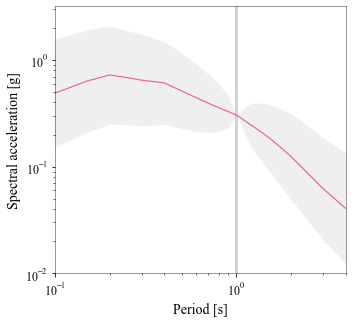

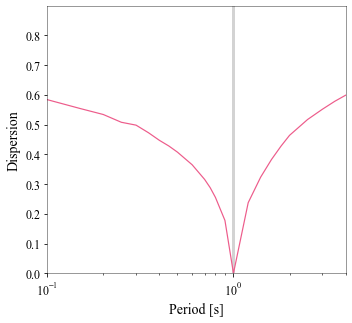

In [8]:
# Create the target spectra
CS1.create(site_param={'vs30': Vs30},
                                rup_param={'rake': rake, 'mag': [mag]},
                                dist_param={'rjb': [rjb], 'rrup': Rrup, 'rx': Rx, 'ry0': Ryo}, Hcont=None, T_Tgt_range=T_target, im_T_star=im_T_star,
                                epsilon=None, cond=1, useVar=1, corr_func='baker_jayaram')
print("Target distribution is defined")

CS1.plot_Target(j, save=0, show=1, name_dir=fig_dir)


# Ground motion selection
This next step is where the simulations are performed, obtaining different spectral values for different records.

(See: https://journals.sagepub.com/doi/pdf/10.1193/1.3608002)

The first step is to probabilistically simulate a set of response spectra that comply with the target's mean and variance through Monte Carlo sampling:



```
def simulate_spectra(self):

  # Generate simulated response spectra with best matches to the target values
---------------------------------------------------
  # iterates for a set number of trials

  for j in range(self.nTrials):
      specDict[j] = np.zeros((self.nGM, nT))
      for i in range(self.nGM):

# Monte Carlo Sampling
-----------------------------
          specDict[j][i, :] = np.exp(np.random.multivariate_normal(self.mu_ln, self.cov))

# Computes the best fit 
---------------------------
      devMeanSim = np.mean(np.log(specDict[j]),
                            axis=0) - self.mu_ln  # how close is the mean of the spectra to the target
      devSigSim = np.std(np.log(specDict[j]),
                          axis=0) - self.sigma_ln  # how close is the mean of the spectra to the target
      devSkewSim = skew(np.log(specDict[j]),
                        axis=0)  # how close is the skewness of the spectra to zero (i.e., the target)

      devTotalSim[j] = self.weights[0] * np.sum(devMeanSim ** 2) + \
                        self.weights[1] * np.sum(devSigSim ** 2) + \
                        0.1 * (self.weights[2]) * np.sum(
          devSkewSim ** 2)  # combine the three error metrics to compute a total error

  recUse = np.argmin(np.abs(devTotalSim))  # find the simulated spectra that best match the targets
  self.sim_spec = np.log(specDict[recUse])  # return the best set of simulations
```



For each simulated response spectrum, a ground motion with a similar response spectrum is then selected, and given that the Monte Carlo simulations have the target's mean and variance, it is expected that the selected GM will have it as well.

```
  # Find nGM ground motions, initial subset
  ---------------------

  for i in range(self.nGM):
      err = np.zeros(nBig)
      scaleFac = np.ones(nBig)

      # Calculate the scaling factor
      -------------------------------------------

      if self.isScaled == 1:
          # using conditioning IML
          if self.cond == 1:
              scaleFac = self.im_T_star / sampleBig_imls
          # using error minimization
          elif self.cond == 0:
              scaleFac = np.sum(np.exp(sampleBig) * np.exp(self.sim_spec[i, :]), axis=1) / np.sum(
                  np.exp(sampleBig) ** 2, axis=1)
      else:
          scaleFac = np.ones(nBig)

  # Check Scaling factor limits and repeated records
  ---------------------------------------
      mask1 = scaleFac > self.maxScale
      mask2 = scaleFac < self.minScale
      mask = np.logical_xor(mask1, mask2)
      idxs = np.where(~mask)[0]
      err[mask] = 1000000
      err[~mask] = np.sum((np.log(
          np.exp(sampleBig[idxs, :]) * scaleFac[~mask].reshape(len(scaleFac[~mask]), 1)) -
                            self.sim_spec[i, :]) ** 2, axis=1)
      # to avoid repeating the same records
      for iii in recID:
          if iii > 0:
              err[iii] = 1000000

      recID[i] = int(np.argsort(err)[0])  # record with the minimal error

      if err.min() >= 1000000:
          raise Warning('     Possible problem with simulated spectrum. No good matches found')

      if self.isScaled == 1:
          finalScaleFac[i] = scaleFac[recID[i]]

      # Save the selected spectra
      sampleSmall[i, :] = np.log(np.exp(sampleBig[recID[i], :]) * finalScaleFac[i])

  self.rec_initial_set = sampleSmall  # save the initial set to the self

  # error of the initial set

        if self.cond == 1 and len(self.T_star) == 1:  # if conditioned on SaT, ignore error at T*
            medianErr = np.max(
                np.abs(np.exp(np.mean(sampleSmall[:, ind2], axis=0)) - np.exp(self.mu_ln[ind2])) / np.exp(
                    self.mu_ln[ind2])) * 100
            stdErr = np.max(
                np.abs(np.std(sampleSmall[:, ind2], axis=0) - self.sigma_ln[ind2]) / self.sigma_ln[ind2]) * 100
            if self.useVar == 1:
                SSE_s = weights[0] * np.sum(((np.mean(sampleSmall[:, ind2], axis=0) - self.mu_ln[ind2]) ** 2)) + \
                    weights[1] * np.sum(((np.std(sampleSmall[:, ind2], axis=0) - self.sigma_ln[ind2]) ** 2))
            else:
                SSE_s = np.sum(((np.mean(sampleSmall[:, ind2], axis=0) - self.mu_ln[ind2]) ** 2))  
```

### Greedy optimization

These records are then evaluated and optimized in terms of $\mu$lnSa and $\sigma$lnSa through the greedy optimization process.
The error is computed through: 


\begin{align}
\text{SSE } & = \sum_{j=1}^p\left[ \left( \hat{m}_{lnSa(T_j)}-\mu^{(t)}_{lnSa(T_j)} \right)^2+w\left( \hat{s}_{lnSa(T_j)}-\sigma^{(t)}_{lnSa(T_j)} \right)^2\right]. \\[1em]
\
\end{align}

Where $\hat{m}_{lnSa(T_j)}$ and $\hat{s}_{lnSa(T_j)}$ are the sample's mean and standard deviation, and $\mu_{lnSa(T_j)}$ and $\sigma_{lnSa(T_j)}$ are the target's mean and standard deviation, respectively.


```

    def find_rec(sampleSmall, scaleFac, mu_ln, sigma_ln, recIDs):
      for j in range(nBig):
        if not np.any(recIDs == j):
              # Add to the sample the scaled spectra
              temp = np.zeros((1, len(sampleBig[j, :])))
              temp[:, :] = sampleBig[j, :]
              tempSample = np.concatenate((sampleSmall, temp + np.log(scaleFac[j])), axis=0)

            # Compute the SSE
            ---------------------
              devMean = mean_numba(tempSample) - mu_ln  # Compute deviations from target
              devSig = std_numba(tempSample) - sigma_ln
              devTotal = weights[0] * np.sum(devMean * devMean) + weights[1] * np.sum(
                  devSig * devSig)  # this is SSEs

            # Check if we exceed the scaling limit and if the record is already in the set
            ---------------------------------------
            if scaleFac[j] > maxScale or np.any(recIDs == j) or scaleFac[j] < minScale:
                devTotal = devTotal + 1000000
            # Penalize bad spectra
            elif penalty > 0:
                for m in range(nGM):
                    devTotal = devTotal + np.sum(
                        np.abs(np.exp(tempSample[m, :]) > np.exp(mu_ln + 3.0 * sigma_ln))) * penalty
                    devTotal = devTotal + np.sum(
                        np.abs(np.exp(tempSample[m, :]) < np.exp(mu_ln - 3.0 * sigma_ln))) * penalty
            # Should cause improvement and record should not be repeated
            if devTotal < minDev:
                minID = j
                minDev = devTotal
    return minID

    # start across all records 
    ------------------------------------
    for k in range(self.nLoop):  # Number of passes
        for i in range(self.nGM):  # Loop for nGM
            sampleSmall = np.delete(sampleSmall, i, 0)  # it deletes record i
            oldrec = recID[i]
            recID = np.delete(recID, i)
            # Calculate the scaling factor
            if self.isScaled == 1:
                # using conditioning IML
                if self.cond == 1:
                    scaleFac = self.im_T_star / sampleBig_imls
                # using error minimization
                elif self.cond == 0:
                    scaleFac = np.sum(np.exp(sampleBig) * np.exp(self.sim_spec[i, :]), axis=1) / np.sum(
                        np.exp(sampleBig) ** 2, axis=1)
            else:
                scaleFac = np.ones(nBig)

            # Try to add a new spectra to the subset list

            minID = find_rec(sampleSmall, scaleFac, self.mu_ln, self.sigma_ln, recID)

            sampleSmall_new = np.concatenate(
                (sampleSmall[:i, :],
                  sampleBig[minID, :].reshape(1, sampleBig.shape[1]) + np.log(scaleFac[minID]),
                  sampleSmall[i:, :]), axis=0)
            recID_new = np.concatenate((recID[:i], np.array([minID]), recID[i:]))
       
            # Calculates the new SSE
            .............................
            if self.cond == 1 and len(self.T_star) == 1:
                SSE_s_new = weights[0] * np.sum(
                    ((np.mean(sampleSmall_new[:, ind2], axis=0) - self.mu_ln[ind2]) ** 2)) + \
                            weights[1] * np.sum(
                    ((np.std(sampleSmall_new[:, ind2], axis=0) - self.sigma_ln[ind2]) ** 2))
            else:
                SSE_s_new = weights[0] * np.sum(
                    ((np.mean(sampleSmall_new, axis=0) - self.mu_ln) ** 2)) + \
                            weights[1] * np.sum(
                    ((np.std(sampleSmall_new, axis=0) - self.sigma_ln) ** 2))

            # Checks for improvement, otherwise goes back to previous record
            if SSE_s_new < SSE_s:  # if it is improved
                if self.isScaled == 1:
                    finalScaleFac[i] = scaleFac[minID]
                else:
                    finalScaleFac[i] = 1
                sampleSmall = sampleSmall_new
                recID = recID_new
                SSE_s = SSE_s_new
            else:
                minID = oldrec
                sampleSmall = np.concatenate((sampleSmall[:i, :],
                                              sampleBig[minID, :].reshape(1, sampleBig.shape[1]) + np.log(
                                                  finalScaleFac[i]), sampleSmall[i:, :]), axis=0)
                recID = np.concatenate((recID[:i], np.array([minID]), recID[i:]))
                if self.cond == 1 and len(self.T_star) == 1:
                    SSE_s = weights[0] * np.sum(((np.mean(sampleSmall[:, ind2], axis=0) - self.mu_ln[ind2]) ** 2)) + \
                            weights[1] * np.sum(((np.std(sampleSmall[:, ind2], axis=0) - self.sigma_ln[ind2]) ** 2))
                else:
                    SSE_s = weights[0] * np.sum(((np.mean(sampleSmall, axis=0) - self.mu_ln) ** 2)) + \
                            weights[1] * np.sum(((np.std(sampleSmall, axis=0) - self.sigma_ln) ** 2))
                              ```

In the end the records producing the lowest SSE are chosen for the final selection.

Before greedy optimization
 Max error in median = 24.43 %
 Max error in standard deviation = 25.45 %
 SSE_s = 23.93 %
Starting Greedy Optimization
After greedy optimization:
 Max error in median = 22.30 %
 Max error in standard deviation = 26.27 %
 SSE_s = 22.03 %


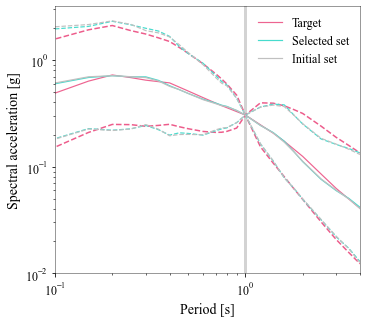

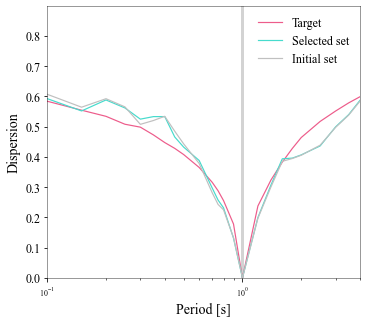

Records selected!


In [9]:
# Select ground motion records
CS1.select(nGM=nGM, selection=2, Sa_def='RotD50', isScaled=1, maxScale=maxSF, minScale=minSF, Mw_lim=[4, 8],
            DB_lim=['Ridge','NGA','GNS'], Vs30_lim=Vs30_lims, Rjb_lim=None, fault_lim=None, freefield=True, nTrials=20, weights=[1, 2, 0.3], seedValue=0, nLoop=20, penalty=1, tol=10)
CS1.plot_sel((j), save=1, show=1, initial=1, name_dir=fig_dir)  
All_CS.append(CS1)


print("Records selected!")

# Exporting data
Now that the CS algorithm is done, we have obtained our record set, this set contains information about the records, such as the event name, network and station (can be downloaded from the ESM database - https://esm-db.eu/#/home) or alternatively, the file name (if all the database is previously downloaded), scaling factors, ground motion data and causative parameters.

In [12]:
from sys import intern
resdata={'Network':All_CS[0].eq_ID,'Station':All_CS[0].eq_ID,'Event':All_CS[0].eq_ID,'SF':All_CS[0].rec_scale,'dt':All_CS[0].dt,'npts':All_CS[0].nstp,'Mw':All_CS[0].rec_Mw,'R':All_CS[0].rec_Rjb,'Vs30':All_CS[0].rec_Vs30,'Fname1':All_CS[0].rec_h1,'Fname2':All_CS[0].rec_h2,'url':All_CS[0].eq_ID}
import pandas as pd 
ResDF = pd.DataFrame(data=resdata)

# get event names, network and station for ESM search
for inn in range(nGM):
  s = ResDF.Fname1[inn]
  start = s.find(".D.") + len(".D.")
  end = s.find(".ACC.")
  EvenID = s[start:end]
  partitioned_string = s.partition('.')
  ResDF.Network[inn]=partitioned_string[0]
  ResDF.Event[inn]=EvenID
  start = s.find(partitioned_string[0]) + len(partitioned_string[0])+1
  end1 = s.find("..")
  end2 =s.find(".00.")
  end = max(end1,end2)
  Statr = s[start:end]
  ResDF.Station[inn]=Statr
  try:
    urli='https://esm-db.eu/#/waveform/'+ResDF.Network[inn]+'/'+ResDF.Station[inn]+'/00/'+EvenID+'/HG'
  except:
    urli='error'
  ResDF.url[inn]=urli
# export table
ResDF.to_csv(output_dir+'/RecSelection_IM_'+str(nIM)+'.csv')
ResDF

,Network,Station,Event,SF,dt,npts,Mw,R,Vs30,Fname1,Fname2,url
0,TK,4101,TK-1999-0077,1.034502,0.005,23998,7.60,7.12,827.000000,TK.4101..HNE.D.TK-1999-0077.ACC.MP.ASC,TK.4101..HNN.D.TK-1999-0077.ACC.MP.ASC,error
1,A,C1062,TK-1999-0415,2.239521,0.005,8444,7.30,3.62,832.389543,A.C1062..HNE.D.TK-1999-0415.ACC.MP.ASC,A.C1062..HNN.D.TK-1999-0415.ACC.MP.ASC,https://esm-db.eu/#/waveform/A/C1062/00/TK-199...
2,IT,MSC,EMSC-20161030_0000029,2.854385,0.005,9561,6.50,22.96,756.133791,IT.MSC..HGE.D.EMSC-20161030_0000029.ACC.MP.ASC,IT.MSC..HGN.D.EMSC-20161030_0000029.ACC.MP.ASC,https://esm-db.eu/#/waveform/IT/MSC/00/EMSC-20...
3,IT,TLN,EMSC-20160824_0000006,3.126342,0.005,13071,6.00,37.82,910.226117,IT.TLN..HGE.D.EMSC-20160824_0000006.ACC.MP.ASC,IT.TLN..HGN.D.EMSC-20160824_0000006.ACC.MP.ASC,https://esm-db.eu/#/waveform/IT/TLN/00/EMSC-20...
4,IT,MNF,EMSC-20161026_0000095,3.014838,0.005,7052,5.90,6.84,980.827142,IT.MNF..HGE.D.EMSC-20161026_0000095.ACC.MP.ASC,IT.MNF..HGN.D.EMSC-20161026_0000095.ACC.MP.ASC,https://esm-db.eu/#/waveform/IT/MNF/00/EMSC-20...
5,IT,AQG,IT-2009-0009,0.667687,0.005,20000,6.10,0.00,696.000000,IT.AQG..HNE.D.IT-2009-0009.ACC.MP.ASC,IT.AQG..HNN.D.IT-2009-0009.ACC.MP.ASC,https://esm-db.eu/#/waveform/IT/AQG/00/IT-2009...
6,BO,NIG1C,JP-2004-0002,0.397011,0.005,15000,6.60,0.90,647.025760,BO.NIG1C.00.HNE.D.JP-2004-0002.ACC.MP.ASC,BO.NIG1C.00.HNN.D.JP-2004-0002.ACC.MP.ASC,https://esm-db.eu/#/waveform/BO/NIG1C/00/JP-20...
7,BO,FKS0F,EMSC-20110411_0000023,3.359859,0.005,17996,6.60,17.60,609.000000,BO.FKS0F.00.HNE.D.EMSC-20110411_0000023.ACC.MP...,BO.FKS0F.00.HNN.D.EMSC-20110411_0000023.ACC.MP...,https://esm-db.eu/#/waveform/BO/FKS0F/00/EMSC-...
8,IT,MSCT,EMSC-20161030_0000029,2.745333,0.005,11000,6.50,22.97,757.454328,IT.MSCT..HGE.D.EMSC-20161030_0000029.ACC.MP.ASC,IT.MSCT..HGN.D.EMSC-20161030_0000029.ACC.MP.ASC,https://esm-db.eu/#/waveform/IT/MSCT/00/EMSC-2...
9,IT,PZI1,EMSC-20161030_0000029,3.758584,0.005,16565,6.50,31.35,855.838905,IT.PZI1..HGE.D.EMSC-20161030_0000029.ACC.MP.ASC,IT.PZI1..HGN.D.EMSC-20161030_0000029.ACC.MP.ASC,https://esm-db.eu/#/waveform/IT/PZI1/00/EMSC-2...


# Selected records

Now with everything done, the records can be processed in many ways and finally downloaded for time history analysis...

(0.07, 4.0)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


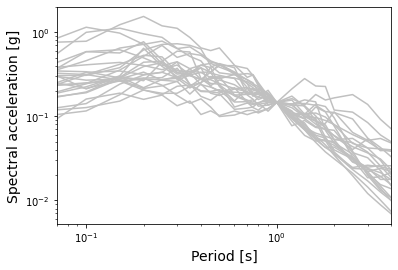

In [ ]:
for k in range(nGM):
  plt.loglog(All_CS[0].T,np.exp(All_CS[0].rec_spec[k,:]),'silver')
#plt.loglog(All_CS[0].T,np.exp(All_CS[0].mu_ln),'r'); # Target
plt.xlabel('Period [s]',fontsize=14)
plt.ylabel('Spectral acceleration [g]',fontsize=14)
plt.xlim(All_CS[0].T[0],All_CS[0].T[-1])

See the selected records, relevant data and download at the ESM website.

Ideally, it is better to have the full DB files so that they can be selected, processed and used automatically for the relevant analyses

In [ ]:
for zz in ResDF.url:
  print(zz)

https://esm-db.eu/#/waveform/IV/CIMA/00/EMSC-20161026_0000095/HG
https://esm-db.eu/#/waveform/KO/DEMR/00/EMSC-20151006_0000093/HG
https://esm-db.eu/#/waveform/BO/FKO19/00/USGS-us20005iis/HG
https://esm-db.eu/#/waveform/A/C1062/00/TK-1999-0415/HG
https://esm-db.eu/#/waveform/IT/AQG/00/IT-2009-0009/HG
https://esm-db.eu/#/waveform/IT/AQK/00/IT-2009-0102/HG
https://esm-db.eu/#/waveform/A/C1061/00/TK-1999-0415/HG
https://esm-db.eu/#/waveform/IV/RM33/00/EMSC-20160824_0000006/HG
https://esm-db.eu/#/waveform/IT/TLN/00/EMSC-20161026_0000095/HG
https://esm-db.eu/#/waveform/IT/AMT/00/EMSC-20160824_0000006/HG
https://esm-db.eu/#/waveform/IT/AQK/00/IT-2009-0121/HG
https://esm-db.eu/#/waveform/IT/BZZ/00/IT-2009-0102/HG
https://esm-db.eu/#/waveform/IV/GUMA/00/EMSC-20161026_0000095/HG
https://esm-db.eu/#/waveform/TK/4101/00/TK-1999-0077/HG
https://esm-db.eu/#/waveform/IV/T1214/00/EMSC-20161026_0000095/HG
https://esm-db.eu/#/waveform/I1/CHT/00/IR-2005-0044/HG
https://esm-db.eu/#/waveform/BO/FKO17/00/US

More information on CS can be found [here](https://www.youtube.com/watch?v=1B6d9rrMPu0) (video by Jack Baker on CMS)

If you are more familiar with MATLAB, we have developed record selection scripts based on the ones by Jack Baker (https://github.com/bakerjw/CS_Selection) originally developed for NGA, modified for the ESM database.